# Finding exoplanets

We will download data from the recently launched Transiting Exoplanet Survey Satellite (TESS).

We will look at $\pi$ men, and see if we can spot any exoplanet transits.

In [169]:
import lightkurve as lk
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from typing import List
import scipy as sp
from astropy.utils.masked import Masked as AstroMasked

We can download the data from the online databases, and then view it for ourselves.

In [170]:
download_tpf = lk.search_targetpixelfile("TIC 261136679", mission="TESS", sector="1", author="SPOC").download()
downloaded_curve = lk.search_lightcurve("TIC 261136679", mission="TESS", sector="1", author="SPOC").download()

Let's look at the telescope data over time.

In [171]:
fig, ax = plt.subplots(figsize=(8, 8))
download_tpf.animate(aspect="auto", ax=ax, step=100, interval=60)

We can see where the light was collected from for the star.

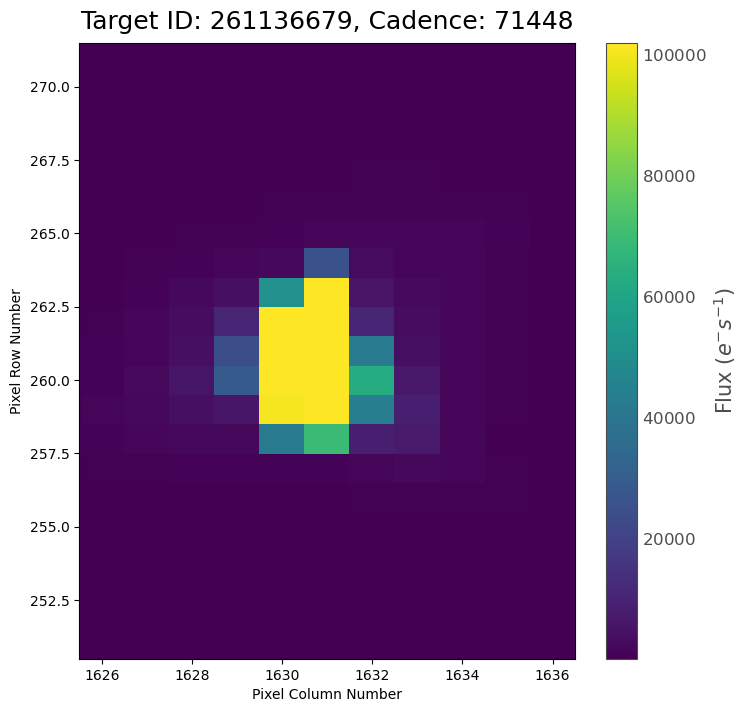

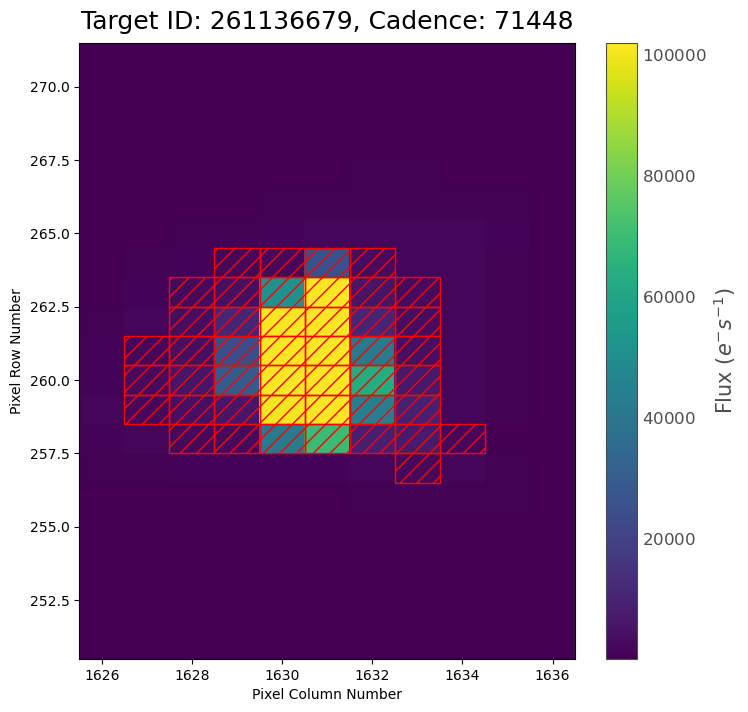

In [172]:
fig2, ax2 = plt.subplots(figsize=(8, 8))
download_tpf.plot(aspect="auto", frame=1000, ax=ax2)
fig3, ax3 = plt.subplots(figsize=(8, 8))
download_tpf.plot(aspect="auto", frame=1000, ax=ax3, aperture_mask=download_tpf.pipeline_mask)
plt.show()

We can look at the total light from the star over time.

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

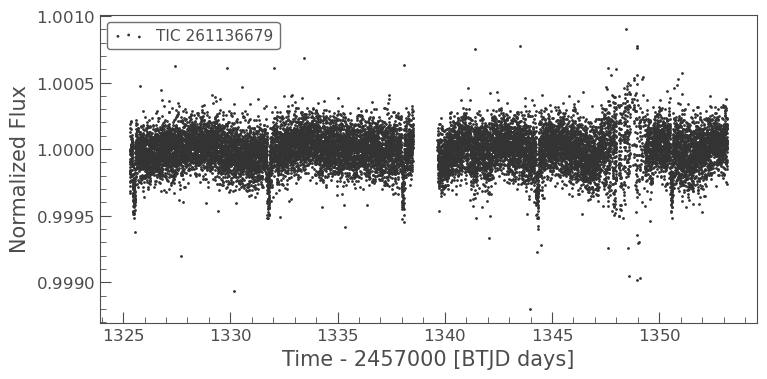

In [173]:
plt.close(fig)

normalised_curve = downloaded_curve.normalize()
normalised_curve.scatter()

Let's have a look at these dips closer up.

[(1331.6, 1331.9), (0.9993, 1.0005)]

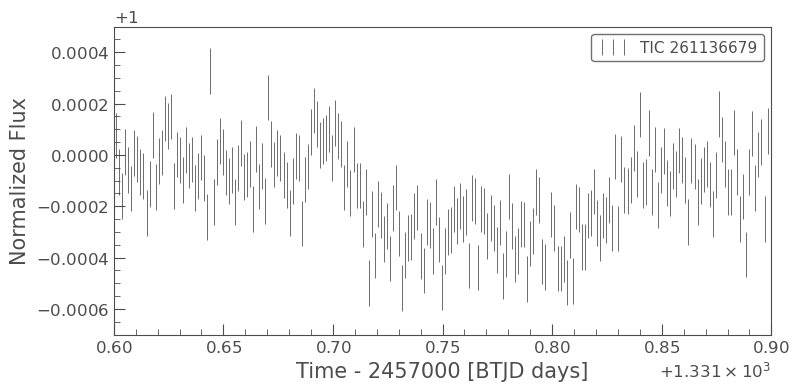

In [174]:
normalised_curve.errorbar().set(xlim=(1331.6, 1331.9), ylim=(0.9993, 1.0005))

In [175]:
binned_curve = normalised_curve.bin(0.01)

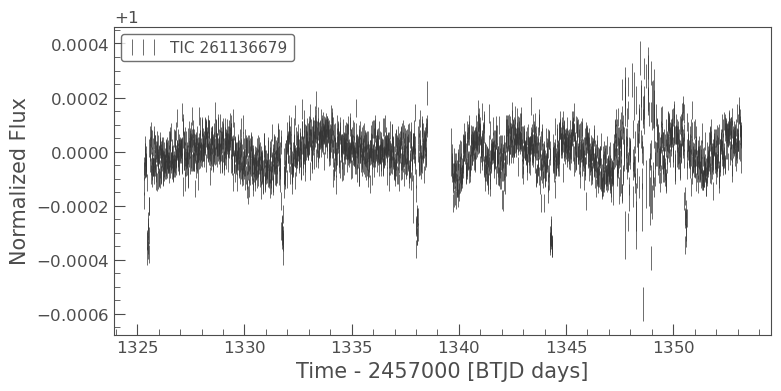

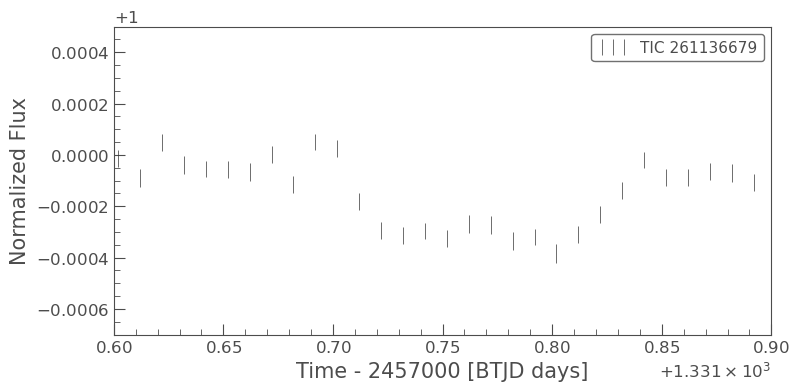

In [176]:
binned_curve.errorbar()
binned_curve.errorbar().set(xlim=(1331.6, 1331.9), ylim=(0.9993, 1.0005))
plt.show()

6.260425257716689 d
6.2643291700753645 d


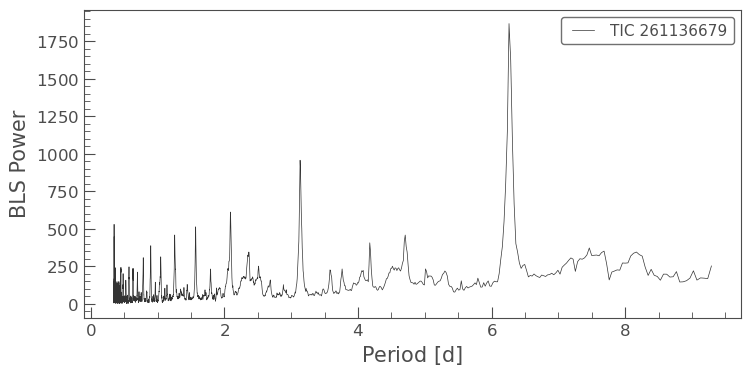

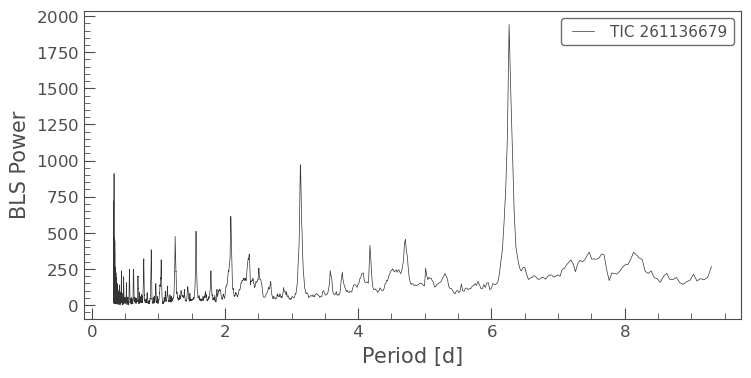

In [177]:
periodogram = binned_curve.to_periodogram(method="bls", oversample=10)
periodogram.plot()
print(periodogram.period_at_max_power)

periodogram_unbinned = normalised_curve.to_periodogram(method="bls", oversample=10)
periodogram_unbinned.plot()
print(periodogram_unbinned.period_at_max_power)

plt.show()

[]

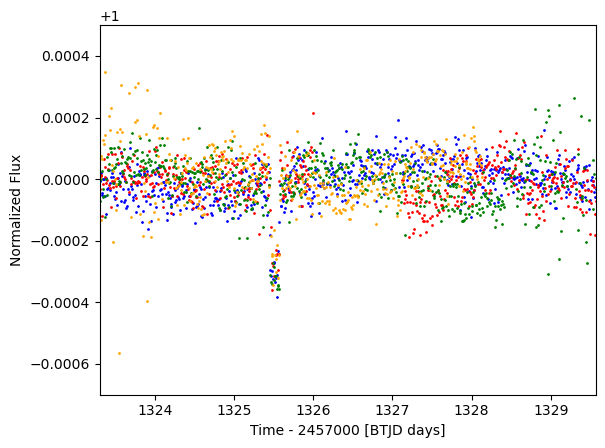

In [178]:
period = periodogram_unbinned.period_at_max_power
graph_offset = -2

colors = ['blue', 'red', 'green', 'orange', 'black']

fig4, ax4 = plt.subplots()

range_graph = ((binned_curve.time[0] + period * 0).value + graph_offset,
               (binned_curve.time[0] + period * 1).value + graph_offset)
 
ax4.set(xlim=range_graph, ylim=(0.9993, 1.0005))

cloned_binned_curve = binned_curve.copy()

for i in range(5):
    cloned_binned_curve.time = cloned_binned_curve.time - period
   
    cloned_binned_curve.scatter(ax=ax4, color=colors[i])

ax4.get_legend().remove()

plt.plot()

[(-0.2, 0.2)]

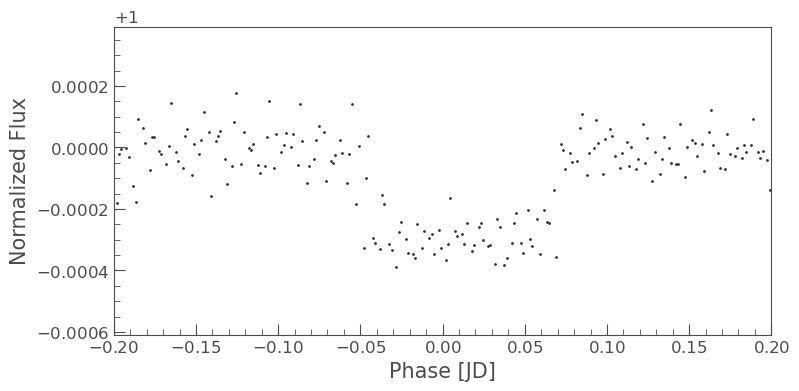

In [179]:
folded_curve = binned_curve.fold(periodogram_unbinned.period_at_max_power, epoch_time=1325.5)
folded_ax = folded_curve.scatter()
folded_ax.get_legend().remove()
folded_ax.set(xlim=(-0.2, 0.2))

In [180]:
def transit_curve(x, t1, t2, t3, t4, C, D, Q):  # this takes a single value and returns the function at that point. note the first value must be the x value
    if x < t1:
        return C
    elif t1 <= x <= t2:
        return D * (x - t1) / (t2 - t1) + C
    elif t2 < x <= t3:
        return Q * (x - t2) * (x - t3) + C + D
    elif t3 < x <= t4:
        return D * (x - t4) / (t3 - t4) + C
    else:
        return C


def fit_transit(x, t1, t2, t3, t4, C, D, Q):  # curve_fit passes the value of x as an array so you need a function to find the value of the function at each x value
    out_arr = []
    for val in x:
        out_arr.append(transit_curve(val, t1, t2, t3, t4, C, D, Q))
    return np.array(out_arr)

t1: val=-0.060056+-0.0016858
t2: val=-0.032260+-0.0019720
t3: val=0.059983+-0.0015507
t4: val=0.077875+-0.0012507
C: val=1.000001+-0.0000007
D: val=-0.000299+-0.0000123
Q: val=0.000000+-0.0078980


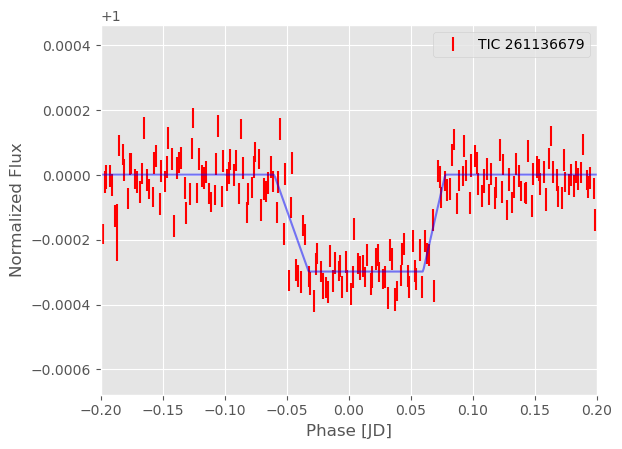

In [181]:
fitting_curve = folded_curve
fitting_curve.flatten(window_length=101, polyorder=3, break_tolerance=None)

time_array = np.array([x.value for x in fitting_curve.time])
flux_array = np.array(fitting_curve.flux)
flux_error_array = np.array(fitting_curve.flux_err)
first_guess = [-0.06, -0.05, 0.06, 0.08, 1, -0.0003, 1]
bounds = np.array([[-0.09, -0.05], [-0.07, -0.03], [0.02, 0.07], [0.04, 0.09], [0.9999, 1.0001], [-0.0005, -0.0001], [0, 10]]).T

invalid_indexes = np.argwhere(np.isnan(flux_array))
# mask = np.zeros_like(flux_array)
# mask[invalid_indexes] = 1
# 
# flux_array = np.ma.masked_array(flux_array, mask=mask)
# flux_error_array = np.ma.masked_array(flux_error_array, mask=mask)
# 
# print(flux_array)
# 
# print(np.count_nonzero(~np.isnan(flux_array)))

flux_array = np.delete(flux_array, invalid_indexes)
time_array = np.delete(time_array, invalid_indexes)
flux_error_array = np.delete(flux_error_array, invalid_indexes)

fit_data = sp.optimize.curve_fit(fit_transit, time_array, flux_array, p0=first_guess, bounds=bounds, absolute_sigma=True, sigma=flux_error_array)

names = ["t1", "t2", "t3", "t4", "C", "D", "Q"]

for name, param, param_sd in zip(names, fit_data[0], np.sqrt(np.diag(fit_data[1]))):
    # transit_params[0][name] = {"val": param,
    #                            "sd": param_sd}
    print(f"{name}: val={param:.6f}+-{param_sd:.7f}")

x_data = np.linspace(-0.2, 0.2, 500)
y_data = fit_transit(x_data, *fit_data[0])
ax = fitting_curve.errorbar(style="ggplot", alpha=1, color="r")
ax.plot(x_data, y_data, label="Best fit for transit", alpha=0.5, color="b")
ax.set(xlim=(x_data.min(), x_data.max()))

plt.show()

[(0.9995, 1.0005)]

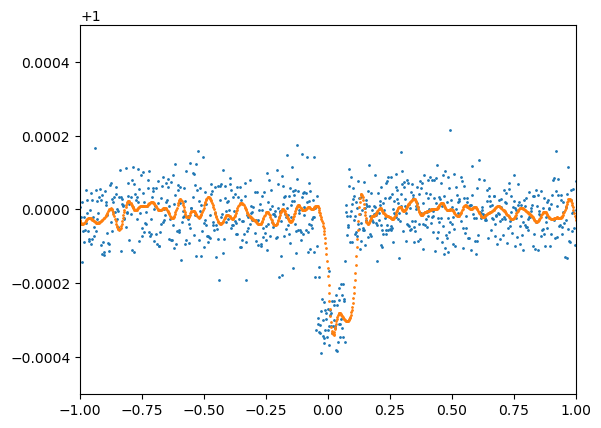

In [182]:
fitting_curve = folded_curve
fitting_curve.flatten(window_length=101, polyorder=3, break_tolerance=None)

time_array = np.array([x.value for x in fitting_curve.time])
flux_array = np.array(fitting_curve.flux)
flux_error_array = np.array(fitting_curve.flux_err)

invalid_indexes = np.argwhere(np.isnan(flux_array))
# mask = np.zeros_like(flux_array)
# mask[invalid_indexes] = 1
# 
# flux_array = np.ma.masked_array(flux_array, mask=mask)
# flux_error_array = np.ma.masked_array(flux_error_array, mask=mask)
# 
# print(flux_array)
# 
# print(np.count_nonzero(~np.isnan(flux_array)))

flux_array = np.delete(flux_array, invalid_indexes)
time_array = np.delete(time_array, invalid_indexes)
flux_error_array = np.delete(flux_error_array, invalid_indexes)

sos = sp.signal.butter(10, 50, 'lp', fs=1000, output='sos')
flux_filt_array = sp.signal.sosfilt(sos, flux_array)

fig, ax = plt.subplots()
ax.scatter(time_array, flux_array, s=1)
ax.scatter(time_array, flux_filt_array, s=1)

ax.set(xlim=(-1, 1))
ax.set(ylim=(0.9995, 1.0005))

t1: val=-0.051656+-0.0016156
t2: val=-0.030173+-0.0019269
t3: val=0.069986+-0.0018978
t4: val=0.089997+-0.0015201
C: val=1.000000+-0.0000007
D: val=-0.000272+-0.0000127
Q: val=0.009789+-0.0063528


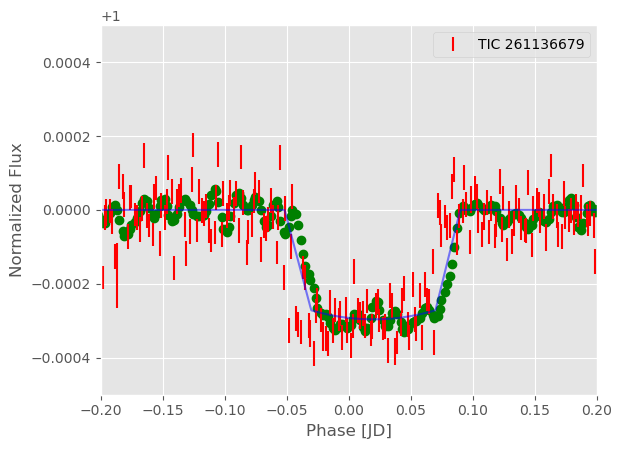

In [183]:
fitting_curve = folded_curve
fitting_curve.flatten(window_length=101, polyorder=3, break_tolerance=None)

time_array = np.array([x.value for x in fitting_curve.time])
flux_array = np.array(fitting_curve.flux)
flux_error_array = np.array(fitting_curve.flux_err)
first_guess = [-0.06, -0.05, 0.06, 0.08, 1, -0.0003, 0.0]
bounds = np.array([[-0.09, -0.05], [-0.07, -0.03], [0.02, 0.07], [0.04, 0.09], [0.9999999999, 1.0000000001], [-0.0005, -0.0001], [0, 0.01]]).T

invalid_indexes = np.argwhere(np.isnan(flux_array))
# mask = np.zeros_like(flux_array)
# mask[invalid_indexes] = 1
# 
# flux_array = np.ma.masked_array(flux_array, mask=mask)
# flux_error_array = np.ma.masked_array(flux_error_array, mask=mask)
# 
# print(flux_array)
# 
# print(np.count_nonzero(~np.isnan(flux_array)))

flux_array = np.delete(flux_array, invalid_indexes)
time_array = np.delete(time_array, invalid_indexes)
flux_error_array = np.delete(flux_error_array, invalid_indexes)

sos = sp.signal.butter(10, 150, 'lp', fs=1000, output='sos')
flux_array = sp.signal.sosfilt(sos, flux_array)

fit_data = sp.optimize.curve_fit(fit_transit, time_array, flux_array, p0=first_guess, bounds=bounds, absolute_sigma=True, sigma=flux_error_array)

names = ["t1", "t2", "t3", "t4", "C", "D", "Q"]

for name, param, param_sd in zip(names, fit_data[0], np.sqrt(np.diag(fit_data[1]))):
    # transit_params[0][name] = {"val": param,
    #                            "sd": param_sd}
    print(f"{name}: val={param:.6f}+-{param_sd:.7f}")

x_data = np.linspace(-0.2, 0.2, 500)
y_data = fit_transit(x_data, *fit_data[0])
ax = fitting_curve.errorbar(style="ggplot", alpha=1, color="r")
ax.scatter(time_array, flux_array, color="g")
ax.plot(x_data, y_data, label="Best fit for transit", alpha=0.5, color="b")
ax.set(xlim=(x_data.min(), x_data.max()))
ax.set(ylim=(0.9995, 1.0005))

plt.show()